In [17]:
import string
import gensim
from pathlib import Path
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [18]:
DATA_DIR = '../data/'
corpus_paths = [ 
    Path(DATA_DIR + 'Negative_train.csv.preprocessed'),
    Path(DATA_DIR + 'Neutral_train.csv.preprocessed'),
    Path(DATA_DIR + 'Positive_train.csv.preprocessed')]

In [19]:
# load VN stopwords
stopword_path = Path(DATA_DIR + 'vietnamese-stopwords-dash.txt')
stopwords = []
with open(str(stopword_path)) as f:
    lines = f.readlines()
    stopwords = [l.strip() for l in lines]
# stopwords[:10]

In [20]:
data = []
for corpus_path in corpus_paths:
    df = pd.read_csv(corpus_path, header=None, names=['text'])
    data.extend(df.text.tolist())

In [21]:
ignored_words = stopwords + list(string.punctuation) + ['email_token', 'url_token', 'number_token', 'phone_token', 'currency_token', 'datetime_token']
def sent_to_words(sentences):
    for sentence in sentences:
        yield [w.strip() for w in sentence.split() if w not in ignored_words]

data_words = list(sent_to_words(data))

print('data_words[:1]:', data_words[:1])

data_words[:1]: [['sản_phẩm', 'dầu', 'xả', 'sunsilk_nourishing', 'soft', 'and_smooth', 'conditionerbao', 'bì', 'chai', 'nhựa', 'màu', 'vàng', 'chóegiá', 'knơi', 'mua', 'siêu_thị', 'co', 'op', 'martđánh', 'giá', 'hãng', 'quảng_cáo', 'dầu', 'xả', 'dưỡng_chất', 'macadamia', 'hỗn_hợp', 'tinh_dầu', 'tự_nhiên', 'giúp', 'nuôi_dưỡng', 'tóc', 'mềm', 'mượt', 'xong', 'tóc', 'mềm', 'mượt', 'dầu', 'xả', 'tóc', 'khô', 'rảnh', 'trọng_lượng', 'chai', 'dầu', 'xả', 'dầu', 'xả', 'xài', 'chai', 'mua', 'mua']]


### Creating Bigram and Trigram Models

In [22]:
# Build the bigram and trigram models
# subset_data_words = 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [23]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
data_words_bigrams = make_bigrams(data_words)
print('data_words_bigrams[:1]: ', data_words_bigrams[:1])

data_words_bigrams[:1]:  [['sản_phẩm', 'dầu_xả', 'sunsilk_nourishing', 'soft', 'and_smooth', 'conditionerbao', 'bì', 'chai', 'nhựa', 'màu', 'vàng', 'chóegiá', 'knơi', 'mua', 'siêu_thị', 'co_op', 'martđánh', 'giá', 'hãng', 'quảng_cáo', 'dầu_xả', 'dưỡng_chất', 'macadamia', 'hỗn_hợp', 'tinh_dầu', 'tự_nhiên', 'giúp', 'nuôi_dưỡng', 'tóc_mềm', 'mượt', 'xong', 'tóc_mềm', 'mượt', 'dầu_xả', 'tóc', 'khô', 'rảnh', 'trọng_lượng', 'chai', 'dầu_xả', 'dầu_xả', 'xài', 'chai', 'mua', 'mua']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [25]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

In [26]:
# Human readable format of corpus (term-frequency)
print('corpus[:1] (term-frequency): ', [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

corpus[:1] (term-frequency):  [[('and_smooth', 1), ('bì', 1), ('chai', 3), ('chóegiá', 1), ('co_op', 1), ('conditionerbao', 1), ('dưỡng_chất', 1), ('dầu_xả', 5), ('giá', 1), ('giúp', 1), ('hãng', 1), ('hỗn_hợp', 1), ('khô', 1), ('knơi', 1), ('macadamia', 1), ('martđánh', 1), ('mua', 3), ('màu', 1), ('mượt', 2), ('nhựa', 1), ('nuôi_dưỡng', 1), ('quảng_cáo', 1), ('rảnh', 1), ('siêu_thị', 1), ('soft', 1), ('sunsilk_nourishing', 1), ('sản_phẩm', 1), ('tinh_dầu', 1), ('trọng_lượng', 1), ('tóc', 1), ('tóc_mềm', 2), ('tự_nhiên', 1), ('vàng', 1), ('xong', 1), ('xài', 1)]]


### Building the Topic Model

In [27]:
# Build LDA model
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


In [28]:
# Print the Keyword in the 10 topics
pp.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[   (   0,
        '0.046*"vé" + 0.038*"tết" + 0.028*"giá" + 0.023*"bay" + '
        '0.018*"khuyến_mãi" + 0.015*"hà_nội" + 0.013*"chương_trình" + '
        '0.013*"vietjet" + 0.010*"áp_dụng" + 0.009*"mobifone"'),
    (   1,
        '0.052*"khai_xuân" + 0.046*"hấp_dẫn" + 0.044*"thay_đổi_nhỏ_khởi_đầu" + '
        '0.044*"rinh_quà" + 0.044*"tràn_đầy_phúc_lộc_thọ" + '
        '0.043*"urlpatt_khám_phá" + 0.043*"gợi_ý_khởi_đầu" + 0.022*"bé" + '
        '0.019*"mẹ" + 0.014*"nestlé"'),
    (   2,
        '0.022*"đi" + 0.019*"đẹp" + 0.015*"mua" + 0.013*"xe" + 0.011*"lắm" + '
        '0.010*"nè" + 0.008*"ko" + 0.007*"re" + 0.006*"e" + 0.006*"giá"'),
    (   3,
        '0.020*"gia_đình" + 0.014*"việt_nam" + 0.012*"sản_phẩm" + '
        '0.012*"gợi_ý" + 0.011*"khởi_đầu" + 0.008*"vn" + 0.008*"urlpatt" + '
        '0.007*"tham_gia" + 0.006*"giúp" + 0.006*"một_chút"')]


###  Compute Model Perplexity and Coherence Score

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                   texts=data_words_bigrams, 
                                                   dictionary=id2word,
                                                   coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.7976719387536

Coherence Score:  0.44068492873336707


### How to find the optimal number of topics for LDA?

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('num_topics: ', num_topics)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=2)

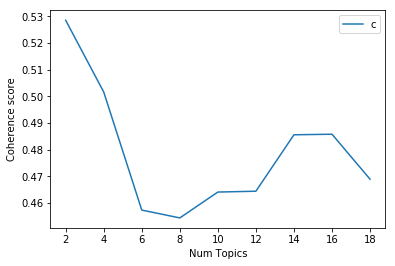

In [51]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
# plt.show()
plt.savefig('compute_coherence_values.png')

### Visualize the topics-keywords

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      32.486153        1       1  0.053391  0.308177
3      32.039375        1       2  0.080226 -0.029466
0      19.530535        1       3  0.215670 -0.197254
1      15.943938        1       4 -0.349288 -0.081457, topic_info=       Category          Freq                   Term         Total  loglift  \
term                                                                          
25473   Default  21547.000000              khai_xuân  21547.000000  30.0000   
88536   Default  23037.000000                     vé  23037.000000  29.0000   
34351   Default  18222.000000  thay_đổi_nhỏ_khởi_đầu  18222.000000  28.0000   
59122   Default  18123.000000               rinh_quà  18123.000000  27.0000   
91568   Default  17937.000000  tràn_đầy_phúc_lộc_thọ  17937.000000  26.0000   
34225   Default  17785.000000       urlpatt_khám_phá  17785.000000  25.0000   
105658  Default  17718.000000         gợi_ý_khởi_đầu  17718.000000  24.0000   
64881   Default  22009.000000                hấp_dẫn  22009.000000  23.0000   
98744   Default  19033.000000                    tết  19033.000000  22.0000   
51262   Default  19227.000000                    giá  19227.000000  21.0000   
76682   Default  11686.000000                    bay  11686.000000  20.0000   
33191   Default  16758.000000               gia_đình  16758.000000  19.0000   
87628   Default  16245.000000                    đẹp  16245.000000  18.0000   
74554   Default   8933.000000                     bé   8933.000000  17.0000   
36604   Default   8939.000000             khuyến_mãi   8939.000000  16.0000   
30779   Default   7672.000000                     mẹ   7672.000000  15.0000   
54775   Default  11290.000000               việt_nam  11290.000000  14.0000   
98892   Default   8170.000000                 hà_nội   8170.000000  13.0000   
88860   Default  10670.000000                     xe  10670.000000  12.0000   
24902   Default  22703.000000                     đi  22703.000000  11.0000   
22643   Default   6773.000000           chương_trình   6773.000000  10.0000   
101774  Default   9667.000000                  gợi_ý   9667.000000   9.0000   
1857    Default  14075.000000                    mua  14075.000000   8.0000   
83261   Default   5792.000000                 nestlé   5792.000000   7.0000   
1395    Default   6481.000000                vietjet   6481.000000   6.0000   
24338   Default   8852.000000               khởi_đầu   8852.000000   5.0000   
21517   Default   8805.000000                    lắm   8805.000000   4.0000   
28960   Default   8712.000000                     nè   8712.000000   3.0000   
22683   Default   5647.000000                   chúc   5647.000000   2.0000   
70570   Default   4558.000000                    sữa   4558.000000   1.0000   
...         ...           ...                    ...           ...      ...   
36085    Topic4   2063.451416                     da   2064.693604   1.8355   
72632    Topic4   4223.854492           phúc_lộc_thọ   4226.615723   1.8354   
21272    Topic4   1504.324341             dinh_dưỡng   1505.510010   1.8353   
409      Topic4   1495.173706                nescafe   1496.377930   1.8353   
39833    Topic4   1188.961914                   thơm   1190.125366   1.8351   
50454    Topic4    991.113770                  maggi    992.278748   1.8349   
12124    Topic4   1618.621216                th_true   1620.544067   1.8349   
8872     Topic4    929.734619                  chóng    930.897949   1.8348   
38945    Topic4    951.726440                    cân    952.932434   1.8348   
99801    Topic4    925.919434                     ly    927.110168   1.8348   
71683    Topic4    870.259583                  bobby    871.411804   1.8348   
1760     Topic4    800.545288               sữa_chua    801.701233   1.8346   
69494    Topic4    890.473755               tràn_đầy    891.868896   1.8345   